In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../")

import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
figure(figsize=(8, 8), dpi=150)

from pySankey import sankey

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1200x1200 with 0 Axes>

In [2]:
# read in files

cnngnn_embed2 = np.load("../data/double_snap_combo_stable_binVer_0325.npy")
df = pd.read_csv("../../../../../data/chl/cHL/crop/OneDrive_1_2-27-2023/reg001_trim_annotations.csv")
df = df.loc[df.cellType != 'Seg Artifact',:]
res05_input = np.load('../data/feature_labels_res0.5.npy')
#print([cnngnn_embed1.shape,df.shape, cnngnn_embed2.shape])

In [3]:
snap = pd.DataFrame(cnngnn_embed2)
snap.to_csv('../data/double_snap_combo_stable_binVer_0325.csv')

### helper function

In [47]:
from scipy.stats import entropy

def cluster_refine(label, label_ref, entropy_threshold = 0.75, concen_threshold = 1, max_breaks = 3, size_lim = 50):
    label_out = label.copy()
    label_out.name = label_out.name + '-refined'
    label_out = label_out.astype(str)
    ll = np.unique(label)
    for l in ll: # each cluster
        ref_l = label_ref[label == l] # get input cluster
        ref_l_freq = ref_l.value_counts() # table
        if entropy(ref_l_freq) > entropy_threshold: # if high entro
            for i in np.arange(max_breaks-1):
                bb = label[label_ref == ref_l_freq.index[i]] # get most abun input cluster
                #print(bb)
                if entropy(bb.value_counts()) < concen_threshold and ref_l_freq.iloc[i] >= size_lim:
                    label_out[(label == l) & (label_ref == ref_l_freq.index[i])] = l + '-' + str(i)
    
    return label_out.astype('category')

### another help to clean results
def clean_cluster(label):
    ll = label.value_counts().index.to_list()
    i = 0
    dd = {}
    for l in ll:
        dd[l] = str(i)
        i = i+1
    res = []
    for item in label:
        t = dd[item]
        res.append(t)
    return res

### check stable combo version

In [48]:
## takes 8min
cnngnn_adata2 = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed2))
sc.pp.scale(cnngnn_adata2)
sc.pp.neighbors(cnngnn_adata2, n_neighbors=15, use_rep='X')
sc.tl.umap(cnngnn_adata2)
sc.tl.leiden(cnngnn_adata2, resolution=1)
# plot
#plt.rcParams["figure.figsize"] = (5, 5)
#sc.pl.umap(cnngnn_adata2, color='leiden', legend_fontsize=17, show=False, palette='tab20')

<AxesSubplot: title={'center': 'snapres1'}, xlabel='UMAP1', ylabel='UMAP2'>

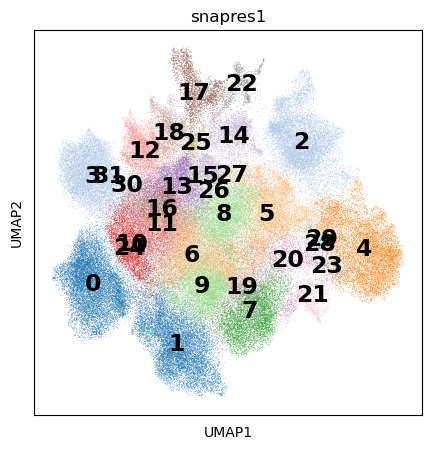

In [49]:
# cellsnap cluster guarding
cnngnn_adata2.obs['input'] = res05_input
snapres1 = cluster_refine(label = cnngnn_adata2.obs['leiden'], label_ref=cnngnn_adata2.obs['input'],
                          concen_threshold = 1.2)
snapres1f = clean_cluster(snapres1)

snapres1.value_counts()
plt.rcParams["figure.figsize"] = (5, 5)
cnngnn_adata2.obs['snapres1'] = snapres1f
sc.pl.umap(cnngnn_adata2, color='snapres1', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

In [50]:
np.unique(snapres1f)

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '4', '5', '6', '7', '8', '9'], dtype='<U2')

### check feature version

<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

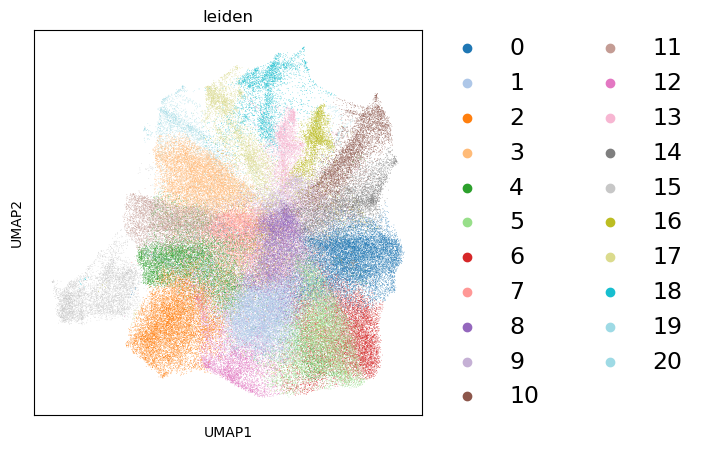

In [51]:
use_marker = ['CD2', 'CD56',
       'CD20', 'CD30', 'CD31', 'CD4', 
         'CD57',  'CD7', 'CD8',
        'Granzyme.B','FoxP3', 'CD11c', 'CD16', 'CD206', 'CD163', 'CD68', 'CD15', 'CD11b',
        'MCT', 'Cytokeratin', 
       'Podoplanin', 'a.SMA'
    ]

feature_adata = ad.AnnData(df.loc[:,use_marker]) # remove meta info and others
sc.pp.scale(feature_adata) # need scale? likey dont matter
sc.pp.neighbors(feature_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1)
# plot
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(feature_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20')

<AxesSubplot: title={'center': 'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

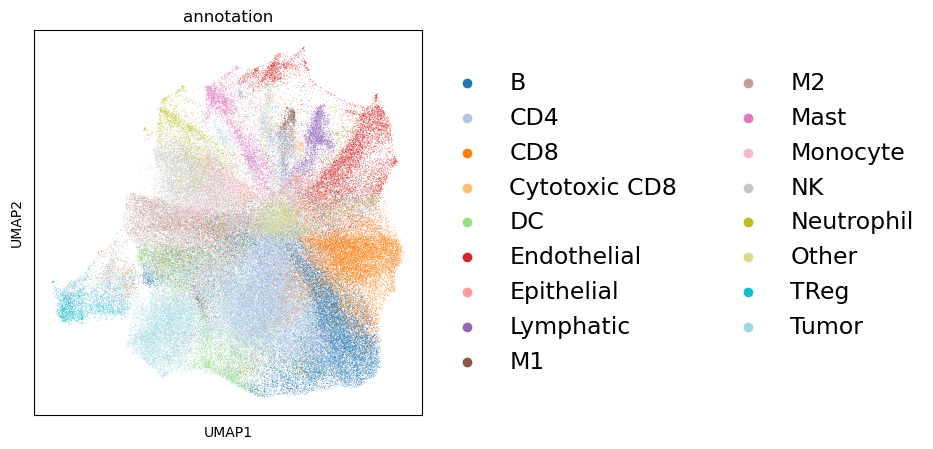

In [52]:
# color by old cell types
plt.rcParams["figure.figsize"] = (5, 5)
feature_adata.obs['annotation'] = df.cellType.values
sc.pl.umap(feature_adata, color='annotation', legend_fontsize=17, show=False, palette='tab20')

### annotation

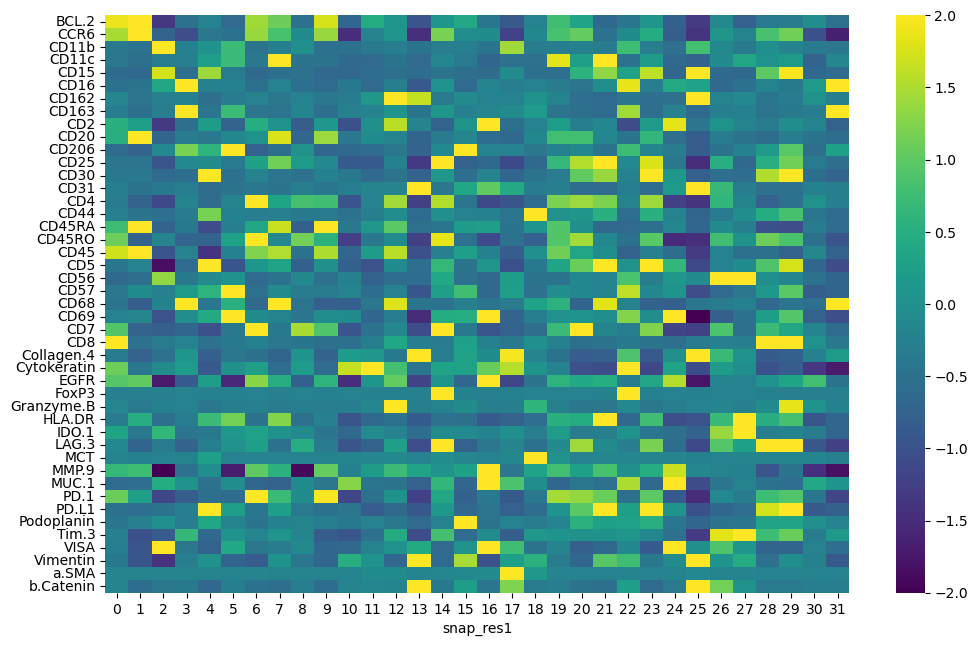

In [74]:
# annotate based on feature expressions
from scipy import stats

df = pd.read_csv("../../../../../data/chl/cHL/crop/OneDrive_1_2-27-2023/reg001_trim_annotations.csv")
df = df.loc[df.cellType != 'Seg Artifact',:]
df['snap_res1'] = cnngnn_adata2.obs['snapres1'].values
tt = df.copy()
tt = tt.drop(['cellLabel', 'X_cent', 'Y_cent', 'cellSize', 'cellType' ], axis=1)
tt = tt.drop(['TCR.g.d', 'T.bet', 'TCRb', 'DAPI.01'], axis=1)
#tt = tt.loc[:,]
tmp = tt.groupby(by='snap_res1').mean()

plot = sns.heatmap((stats.zscore(tmp, axis=0, ddof=0)).T, cmap="viridis", vmin=-2, vmax=2, yticklabels=True, xticklabels=True)
fig = plot.get_figure()

plt.rcParams["figure.figsize"] = (13, 7.5)
fig.savefig('../plots/snapres1_heatmap_0326.svg', dpi = 150) 

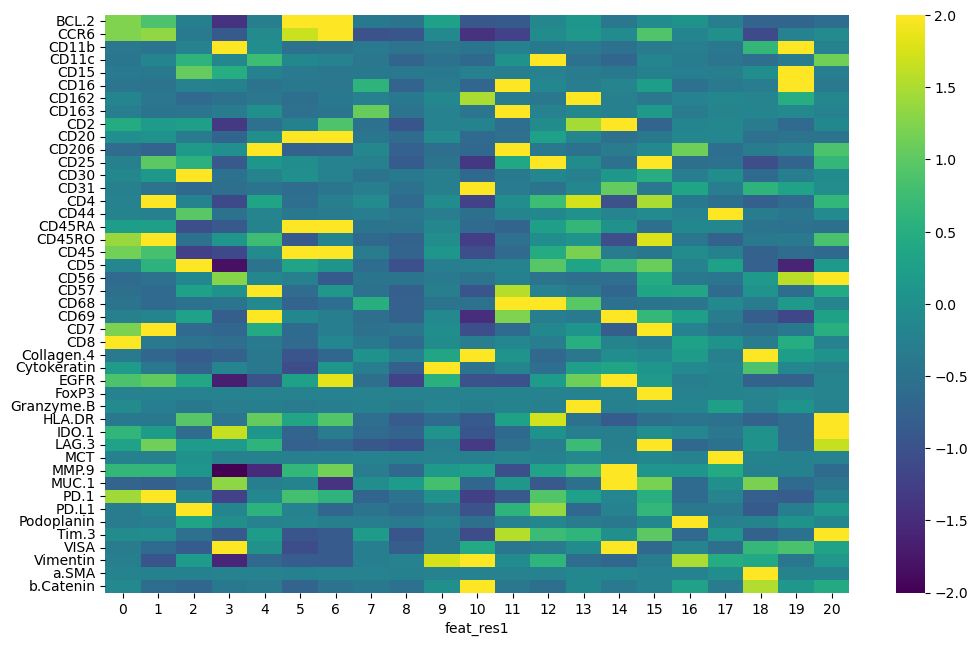

In [76]:
# annotate based on feature expressions
from scipy import stats
df['feat_res1'] = feature_adata.obs['leiden'].values
tt = df.copy()
tt = tt.drop(['cellLabel', 'X_cent', 'Y_cent', 'cellSize', 'cellType', 'snap_res1'], axis=1)
tt = tt.drop(['TCR.g.d', 'T.bet', 'TCRb', 'DAPI.01'], axis=1)
tmp = tt.groupby(by='feat_res1').mean()

plot = sns.heatmap((stats.zscore(tmp, axis=0, ddof=0)).T, cmap="viridis", vmin=-2, vmax=2, yticklabels=True)

plt.rcParams["figure.figsize"] = (12, 7.5)
fig = plot.get_figure()
fig.savefig('../plots/featres1_heatmap_0326.svg', dpi = 150) 

## cell type annotation

In [77]:
## add 
#df['snap_res1'] = df['snap_res1']
df['snap_res1_ann'] = df['snap_res1']

new_cluster_names = {
    '0':'CD8', '1':'B', '2':'NK/Mono/Neutrophil', '3':'Macrophage', '4':'Tumor', '5':'DC',
    '6':'CD4', '7':'DC', '8':'CD4', '9':'CD4', '10':'Stroma', '11':'Stroma',
    '12':'CD4', '13':'Endothelial', '14':'CD4', '15':'Lymphatic', '16':'Stroma', '17':'Endothelial',
    '18':'Mast', '19':'DC', '20':'CD4', '21':'DC','22':'Stroma', '23':'Tumor','24':'Stroma', '25':'Endothelial',
    '26':'NK', '27':'NK','28':'CD8', '29':'CD8','30':'Ohter', '31':'Macrophage'
}

df=df.replace({"snap_res1_ann": new_cluster_names})
#df.head()

In [78]:
df['feat_res1'] = feature_adata.obs['leiden'].values
df['feat_res1_ann'] = df['feat_res1']

new_cluster_names = {
    '0':'CD8', '1':'CD4', '2':'Tumor', '3':'NK/Mono/Neutrophil', '4':'DC', '5':'B',
    '6':'B', '7':'Macrophage', '8':'Mixture', '9':'Stroma', '10':'Endothelial', '11':'Macrophage',
    '12':'DC', '13':'CD4', '14':'Stroma', '15':'CD4', '16':'Lymphatic', '17':'Mast',
    '18':'Endothelial', '19':'NK/Mono/Neutrophil', '20':'Other'
}

df=df.replace({"feat_res1_ann": new_cluster_names})

<AxesSubplot: title={'center': 'snapresann'}, xlabel='UMAP1', ylabel='UMAP2'>

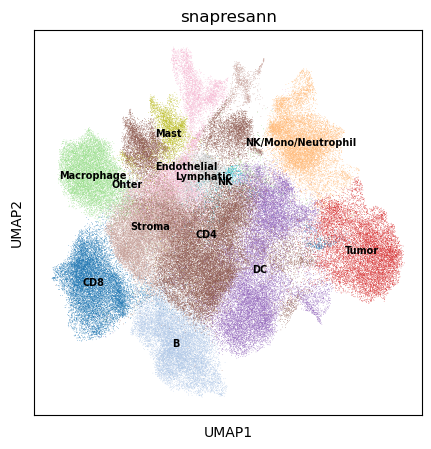

In [79]:
plt.rcParams["figure.figsize"] = (5, 5)
cnngnn_adata2.obs['snapresann'] = df.snap_res1_ann.values
sc.pl.umap(cnngnn_adata2, color='snapresann', legend_fontsize=7, show=False, palette='tab20',
          legend_loc= 'on data')

<AxesSubplot: title={'center': 'featresann'}, xlabel='UMAP1', ylabel='UMAP2'>

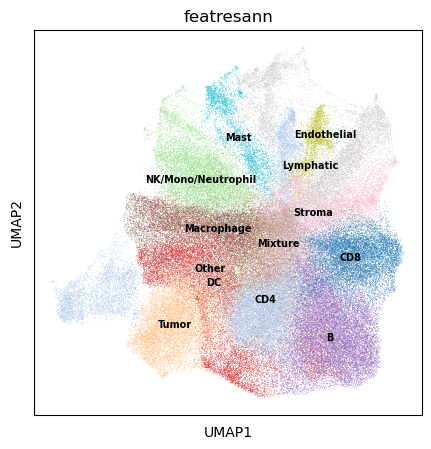

In [80]:
plt.rcParams["figure.figsize"] = (5, 5)
feature_adata.obs['featresann'] = df.feat_res1_ann.values
sc.pl.umap(feature_adata, color='featresann', legend_fontsize=7, show=False, palette='tab20',
          legend_loc= 'on data')

In [83]:
df.head()
df.to_csv('../data/features_and_metadata_withAnn_0326.csv')

## save out the T cell related heatmaps

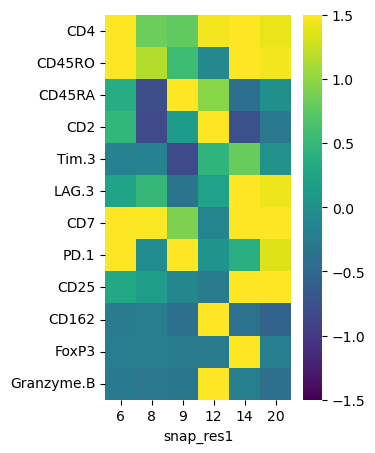

In [87]:
df = pd.read_csv("../../../../../data/chl/cHL/crop/OneDrive_1_2-27-2023/reg001_trim_annotations.csv")
df = df.loc[df.cellType != 'Seg Artifact',:]
df['snap_res1'] = cnngnn_adata2.obs['snapres1'].values
tt = df.copy()
tt = tt.drop(['cellLabel', 'X_cent', 'Y_cent', 'cellSize', 'cellType' ], axis=1)
tt = tt.drop(['TCR.g.d', 'T.bet', 'TCRb', 'DAPI.01'], axis=1)
tmp = tt.groupby(by='snap_res1').mean()
# also we can do a t cell only

tempb = (stats.zscore(tmp, axis=0, ddof=0)).T
#tempb
tempb = tempb.loc[['CD4', 'CD45RO', 'CD45RA', 'CD2', 'Tim.3', 'LAG.3', 'CD7', 'PD.1',
                    'CD25', 'CD162', 'FoxP3' ,'Granzyme.B'],['6','8','9','12','14','20']]

plot2 = sns.heatmap(tempb, cmap="viridis", vmin=-1.5, vmax=1.5)
fig = plot2.get_figure()
plt.rcParams["figure.figsize"] = (3, 5)
fig.savefig('../plots/snap_chlcodex_Ts_0326.svg', dpi = 150) 

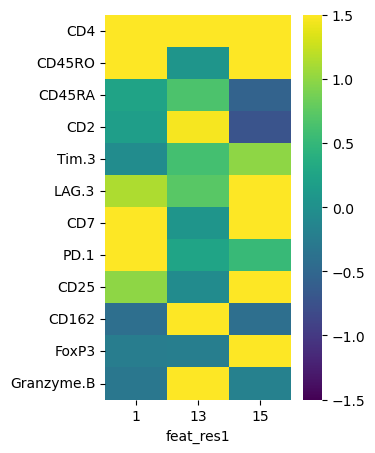

In [88]:
# also we can do a t cell only
df['feat_res1'] = feature_adata.obs['leiden'].values
tt = df.copy()
tt = tt.drop(['cellLabel', 'X_cent', 'Y_cent', 'cellSize', 'cellType', 'snap_res1'], axis=1)
tt = tt.drop(['TCR.g.d', 'T.bet', 'TCRb', 'DAPI.01'], axis=1)
tmp = tt.groupby(by='feat_res1').mean()

tempb = (stats.zscore(tmp, axis=0, ddof=0)).T
#tempb
tempb = tempb.loc[['CD4', 'CD45RO', 'CD45RA', 'CD2', 'Tim.3', 'LAG.3', 'CD7', 'PD.1',
                    'CD25', 'CD162', 'FoxP3' ,'Granzyme.B'],['1', '13', '15']]

plot2 = sns.heatmap(tempb, cmap="viridis", vmin=-1.5, vmax=1.5)
fig = plot2.get_figure()
plt.rcParams["figure.figsize"] = (3, 5)
fig.savefig('../plots/feat_chlcodex_Ts_0326.svg', dpi = 150) 